# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN](https://github.com/junyanz/CycleGAN)
* [A whole list](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.

![GAN diagram](assets/gan_diagram.png)

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector the generator uses to contruct it's fake images. As the generator learns through training, it figures out how to map these random vectors to recognizable images that can fool the discriminator.

The output of the discriminator is a sigmoid function, where 0 indicates a fake image and 1 indicates an real image. If you're interested only in generating new images, you can throw out the discriminator after training. Now, let's see how we build this thing in TensorFlow.

In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Model Inputs

First we need to create the inputs for our graph. We need two inputs, one for the discriminator and one for the generator. Here we'll call the discriminator input `inputs_real` and the generator input `inputs_z`. We'll assign them the appropriate sizes for each of the networks.

>**Exercise:** Finish the `model_inputs` function below. Create the placeholders for `inputs_real` and `inputs_z` using the input sizes `real_dim` and `z_dim` respectively.

In [7]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, shape=(None, real_dim))
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    
    return inputs_real, inputs_z

## Generator network

![GAN Network](assets/gan_network.png)

Here we'll build the generator network. To make this network a universal function approximator, we'll need at least one hidden layer. We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

#### Variable Scope
Here we need to use `tf.variable_scope` for two reasons. Firstly, we're going to make sure all the variable names start with `generator`. Similarly, we'll prepend `discriminator` to the discriminator variables. This will help out later when we're training the separate networks.

We could just use `tf.name_scope` to set the names, but we also want to reuse these networks with different inputs. For the generator, we're going to train it, but also _sample from it_ as we're training and after training. The discriminator will need to share variables between the fake and real input images. So, we can use the `reuse` keyword for `tf.variable_scope` to tell TensorFlow to reuse the variables instead of creating new ones if we build the graph again.

To use `tf.variable_scope`, you use a `with` statement:
```python
with tf.variable_scope('scope_name', reuse=False):
    # code here
```

Here's more from [the TensorFlow documentation](https://www.tensorflow.org/programmers_guide/variable_scope#the_problem) to get another look at using `tf.variable_scope`.

#### Leaky ReLU
TensorFlow doesn't provide an operation for leaky ReLUs, so we'll need to make one . For this you can just take the outputs from a linear fully connected layer and pass them to `tf.maximum`. Typically, a parameter `alpha` sets the magnitude of the output for negative values. So, the output for negative input (`x`) values is `alpha*x`, and the output for positive `x` is `x`:
$$
f(x) = max(\alpha * x, x)
$$

#### Tanh Output
The generator has been found to perform the best with $tanh$ for the generator output. This means that we'll have to rescale the MNIST images to be between -1 and 1, instead of 0 and 1.

>**Exercise:** Implement the generator network in the function below. You'll need to return the tanh output. Make sure to wrap your code in a variable scope, with 'generator' as the scope name, and pass the `reuse` keyword argument from the function to `tf.variable_scope`.

In [9]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    with tf.variable_scope('generator', reuse=reuse): # finish this
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha * h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

## Discriminator

The discriminator network is almost exactly the same as the generator network, except that we're using a sigmoid output layer.

>**Exercise:** Implement the discriminator network in the function below. Same as above, you'll need to return both the logits and the sigmoid output. Make sure to wrap your code in a variable scope, with 'discriminator' as the scope name, and pass the `reuse` keyword argument from the function arguments to `tf.variable_scope`.

In [10]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope("discriminator", reuse=reuse): # finish this
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha * h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

## Hyperparameters

In [8]:
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

## Build network

Now we're building the network from the functions defined above.

First is to get our inputs, `input_real, input_z` from `model_inputs` using the sizes of the input and z.

Then, we'll create the generator, `generator(input_z, input_size)`. This builds the generator with the appropriate input and output sizes.

Then the discriminators. We'll build two of them, one for real data and one for fake data. Since we want the weights to be the same for both real and fake data, we need to reuse the variables. For the fake data, we're getting it from the generator as `g_model`. So the real data discriminator is `discriminator(input_real)` while the fake discriminator is `discriminator(g_model, reuse=True)`.

>**Exercise:** Build the network from the functions you defined earlier.

In [11]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here
g_model = generator(input_z, input_size, g_hidden_size, False,  alpha)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real, d_hidden_size, False, alpha)
d_model_fake, d_logits_fake = discriminator(g_model, d_hidden_size, True, alpha)

## Discriminator and Generator Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_loss_real + d_loss_fake`. The losses will by sigmoid cross-entropies, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits`. We'll also wrap that in `tf.reduce_mean` to get the mean for all the images in the batch. So the losses will look something like 

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

For the real image logits, we'll use `d_logits_real` which we got from the discriminator in the cell above. For the labels, we want them to be all ones, since these are all real images. To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9, for example,  using the parameter `smooth`. This is known as label smoothing, typically used with classifiers to improve performance. In TensorFlow, it looks something like `labels = tf.ones_like(tensor) * (1 - smooth)`

The discriminator loss for the fake data is similar. The logits are `d_logits_fake`, which we got from passing the generator output to the discriminator. These fake logits are used with labels of all zeros. Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

Finally, the generator losses are using `d_logits_fake`, the fake image logits. But, now the labels are all ones. The generator is trying to fool the discriminator, so it wants to discriminator to output ones for fake images.

>**Exercise:** Calculate the losses for the discriminator and the generator. There are two discriminator losses, one for real images and one for fake images. For the real image loss, use the real logits and (smoothed) labels of ones. For the fake image loss, use the fake logits with labels of all zeros. The total discriminator loss is the sum of those two losses. Finally, the generator loss again uses the fake logits from the discriminator, but this time the labels are all ones because the generator wants to fool the discriminator.

In [14]:
# Calculate losses
label_real = tf.ones_like(d_logits_real) * (1 - smooth)
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,\
              labels=label_real))

label_fake = tf.zeros(tf.shape(d_logits_fake), tf.float32)
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
              labels=label_fake))

d_loss = d_loss_real + d_loss_fake

label_g = tf.ones_like(d_logits_fake)
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
         labels=label_g))

## Optimizers

We want to update the generator and discriminator variables separately. So we need to get the variables for each part and build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables that start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.

Then, in the optimizer we pass the variable lists to the `var_list` keyword argument of the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.

>**Exercise: ** Below, implement the optimizers for the generator and discriminator. First you'll need to get a list of trainable variables, then split that list into two lists, one for the generator variables and another for the discriminator variables. Finally, using `AdamOptimizer`, create an optimizer for each network that update the network variables separately.

In [15]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [v for v in t_vars if "generator" in v.name]
d_vars = [v for v in t_vars if "discriminator" in v.name]

d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

## Training

In [16]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3613... Generator Loss: 3.7377
Epoch 2/100... Discriminator Loss: 0.3664... Generator Loss: 3.8751
Epoch 3/100... Discriminator Loss: 0.4788... Generator Loss: 3.6199
Epoch 4/100... Discriminator Loss: 0.5178... Generator Loss: 2.7019
Epoch 5/100... Discriminator Loss: 0.8378... Generator Loss: 3.6976
Epoch 6/100... Discriminator Loss: 1.5764... Generator Loss: 2.6955
Epoch 7/100... Discriminator Loss: 1.2767... Generator Loss: 3.0566
Epoch 8/100... Discriminator Loss: 0.8303... Generator Loss: 3.4495
Epoch 9/100... Discriminator Loss: 0.6332... Generator Loss: 4.2206
Epoch 10/100... Discriminator Loss: 0.9522... Generator Loss: 2.7124
Epoch 11/100... Discriminator Loss: 1.6837... Generator Loss: 2.1232
Epoch 12/100... Discriminator Loss: 1.0060... Generator Loss: 1.9673
Epoch 13/100... Discriminator Loss: 1.0722... Generator Loss: 1.8462
Epoch 14/100... Discriminator Loss: 0.8330... Generator Loss: 3.8630
Epoch 15/100... Discriminator Loss: 1.2332.

## Training loss

Here we'll check out the training losses for the generator and discriminator.

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

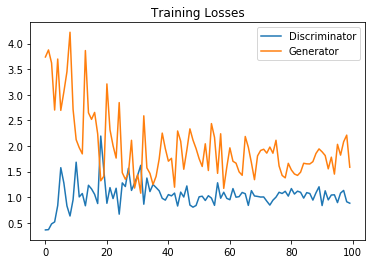

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at images taken while training.

In [19]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [20]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 5, 7, 3, 0, 9. Since this is just a sample, it isn't representative of the full range of images this generator can make.

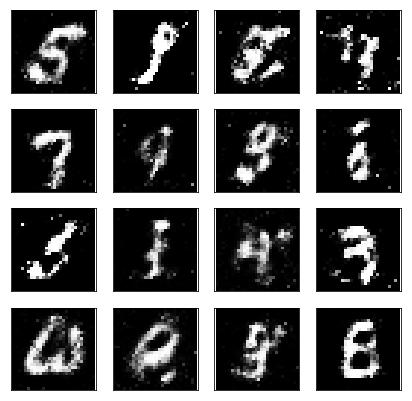

In [21]:
_ = view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs. With bonus optical illusion!

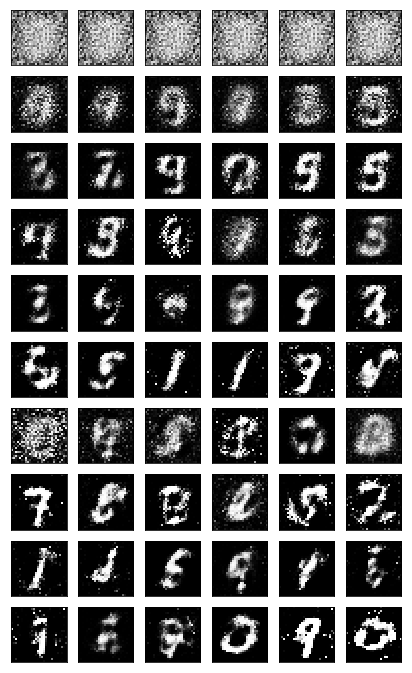

In [22]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise. Looks like 1, 9, and 8 show up first. Then, it learns 5 and 3.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. We just need to pass in a new latent vector $z$ and we'll get new samples!

In [ ]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
view_samples(0, [gen_samples])